In [1]:
from itertools import permutations, combinations
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [83]:
from sklearn.metrics import pairwise_distances

In [3]:
# crystal structure datastructure and analysis measures
import pymatgen
from pymatgen.core import Lattice, Structure, Molecule

# Import structure

## Load data

In [12]:
!mkdir -p tmp

In [4]:
# this cell convert the cifs in iso-8859-1 into utf encoding
cifs = [] # a list of possible cif files

for cif in cifs:
    with open(cif, "r", encoding='iso-8859-1') as f:
        text = f.read()
        
    with (Path("tmp") / Path(cif).name ).open("w") as f:
        f.write(text)

In [120]:
# we use two iron oxide as example here
# cif is downloaded from Crystallography Open Database http://www.crystallography.net/cod/
Fe3O4 = Structure.from_file("assets/1513304.cif")
Fe2O3 = Structure.from_file("assets/1532119.cif")

In [57]:
Fe2O3.lattice, Fe3O4.lattice

(Lattice
     abc : 4.9865 4.9865 13.5016
  angles : 90.0 90.0 119.99999999999999
  volume : 290.741827433301
       A : 4.9865 0.0 3.053350631974139e-16
       B : -2.493249999999999 4.318435675971105 3.053350631974139e-16
       C : 0.0 0.0 13.5016,
 Lattice
     abc : 8.384 8.384 8.384
  angles : 90.0 90.0 90.0
  volume : 589.3235671040001
       A : 8.384 0.0 5.133719382025705e-16
       B : 1.348250029488892e-15 8.384 5.133719382025705e-16
       C : 0.0 0.0 8.384)

In [58]:
lattice = Fe2O3.lattice

## how permuation works

In [59]:
list( permutations((1, 2, 3)) )

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

## Pymatgen structure API

In [60]:
lattice.d_hkl((0,0,1))

13.5016

In [61]:
nbrs = Fe2O3.get_all_neighbors(5)

In [62]:
dm = Fe2O3.distance_matrix

In [63]:
dm.shape

(30, 30)

In [64]:
reci_lattice = lattice.reciprocal_lattice

In [65]:
reci_lattice

Lattice
    abc : 1.4549679047301451 1.4549679047301451 0.46536597937870966
 angles : 90.00000000000001 90.00000000000001 60.00000000000002
 volume : 0.853163150387447
      A : 1.260039167187323 0.7274839523650721 0.0
      B : 0.0 1.4549679047301451 0.0
      C : -2.8495447853910496e-17 -4.935556346740249e-17 0.46536597937870966

In [66]:
reci_lattice.matrix

array([[ 1.26003917e+00,  7.27483952e-01,  0.00000000e+00],
       [ 0.00000000e+00,  1.45496790e+00,  0.00000000e+00],
       [-2.84954479e-17, -4.93555635e-17,  4.65365979e-01]])

## Compute Reciprocal Lattice and spacing between G

In [67]:
list( range(-1, 2) )

[-1, 0, 1]

In [68]:
def create_cell_indices(n):
    indices = set
    for i in range(-n, n+1):
        for j in range(-n, n+1):
            for k in range(-n, n+1):
                # print(i,j,k)
                indices = indices.union( set(permutations((i,j,k))) )
    return list(indices)

In [69]:
def cell_xyz(lattice, n):
    indices = create_cell_indices(n)
    xyzs = lattice.matrix.T @ np.array( indices ).T
    return indices, xyzs

In [70]:
reci_lattice.matrix.shape

(3, 3)

In [71]:
# reci_indices = create_cell_indices(2)
# xyzs = reci_lattice.matrix.T @ np.array( reci_indices ).T
indices, xyzs = cell_xyz(reci_lattice, 4)

In [72]:
xyzs.shape

(3, 729)

In [73]:
lattice

Lattice
    abc : 4.9865 4.9865 13.5016
 angles : 90.0 90.0 119.99999999999999
 volume : 290.741827433301
      A : 4.9865 0.0 3.053350631974139e-16
      B : -2.493249999999999 4.318435675971105 3.053350631974139e-16
      C : 0.0 0.0 13.5016

In [74]:
def generate_dGs(lattice, n=2):
    """
        latttice is in A
        return dG in nm^-1
    """
    
    indices, xyzs = cell_xyz(lattice.reciprocal_lattice, n=n)
    possible_dGs = np.linalg.norm(xyzs, axis=0)
    
    return indices, possible_dGs * 10

In [75]:
indices, possible_dGs = generate_dGs(lattice, n=2) # in nm^-1

In [76]:
(-2, -2, -2) in indices

True

Text(0.5, 0, 'dG ($nm^{-1}$)')

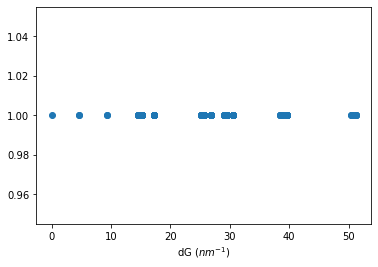

In [77]:
plt.scatter( possible_dGs, np.ones_like(possible_dGs) );
plt.xlabel("dG ($nm^{-1}$)")

## Plot lattice

In [78]:
indices, xyzs = cell_xyz(lattice, 2)

In [79]:
xyzs.shape

(3, 125)

In [80]:
xyzs_min = xyzs.min(axis=1)
xyzs_max=xyzs.max(axis=1)
xyzs_min,xyzs_max

(array([-14.9595    ,  -8.63687135, -27.0032    ]),
 array([14.9595    ,  8.63687135, 27.0032    ]))

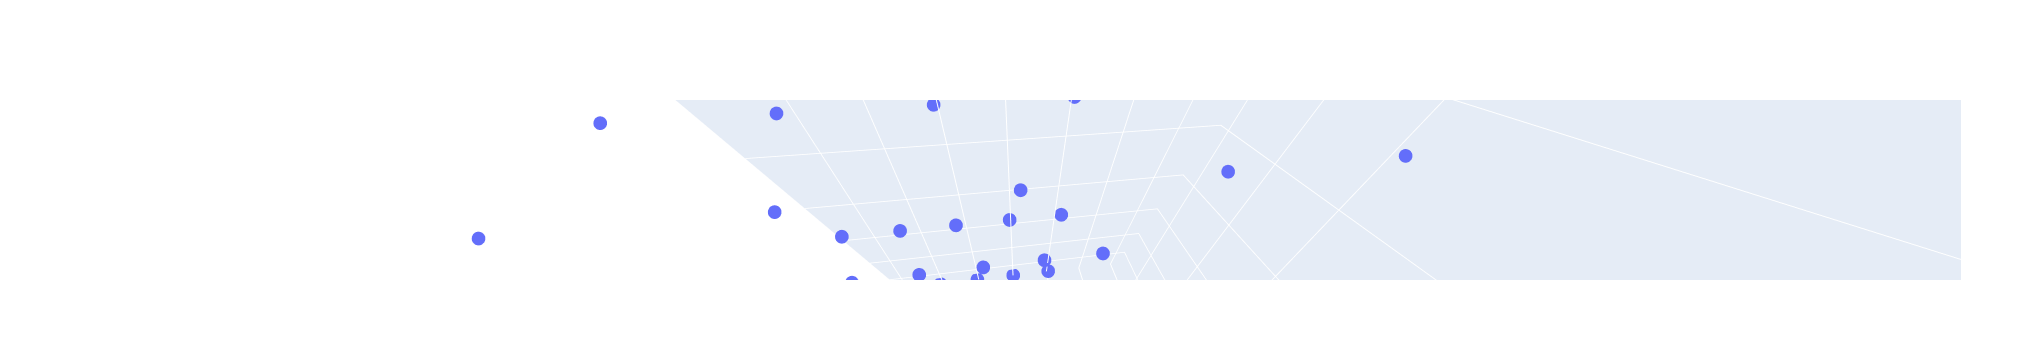

In [81]:
fig = go.Figure()

fig.add_trace( go.Scatter3d(x=xyzs[0], y=xyzs[1], z=xyzs[2], mode="markers"))

x_scale = 1 
y_scale = (xyzs_max[1] - xyzs_min[1]) / (xyzs_max[0] - xyzs_min[0])
z_scale = (xyzs_max[2] - xyzs_min[2]) / (xyzs_max[0] - xyzs_min[0])

fig.update_layout(go.Layout(
    scene=go.layout.Scene(
        aspectmode='manual',
        aspectratio=dict(x=x_scale, y=y_scale, z=z_scale)
    )
))

## plot reciprocal lattice

In [32]:
indices, xyzs = cell_xyz(reci_lattice, 2)

In [33]:
xyzs.shape

(3, 125)

In [34]:
xyzs_min = xyzs.min(axis=1)
xyzs_max=xyzs.max(axis=1)
xyzs_min,xyzs_max

(array([-4.41923243, -5.2144566 , -2.31424873]),
 array([4.41923243, 5.2144566 , 2.31424873]))

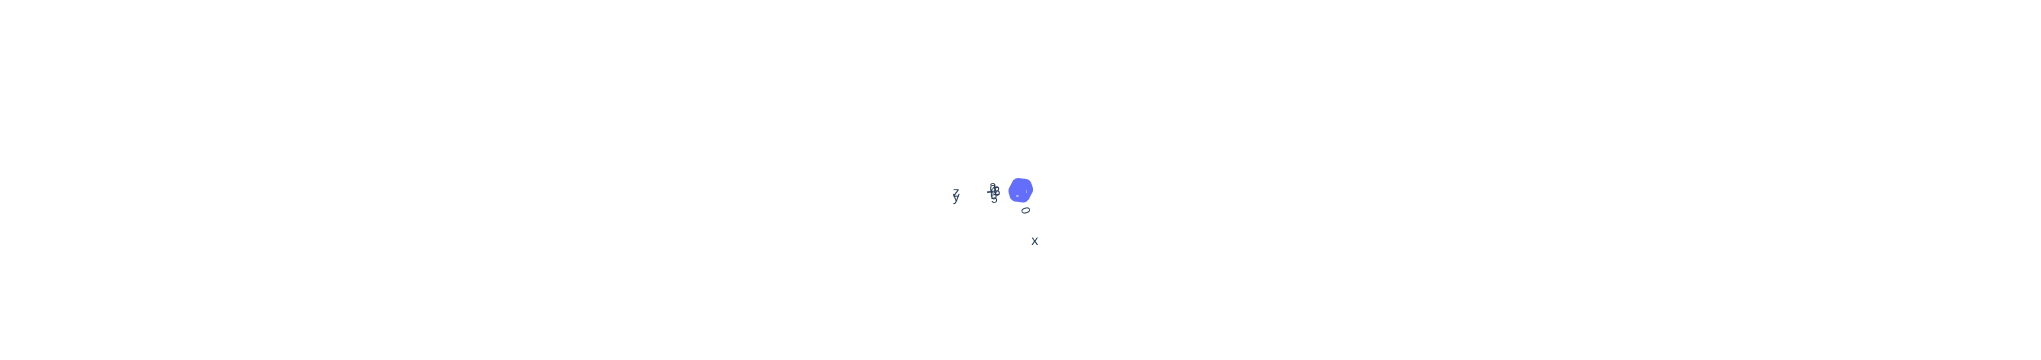

In [35]:
fig = go.Figure()

fig.add_trace( go.Scatter3d(x=xyzs[0], y=xyzs[1], z=xyzs[2], mode="markers"))

x_scale = 1 
y_scale = (xyzs_max[1] - xyzs_min[1]) / (xyzs_max[0] - xyzs_min[0])
z_scale = (xyzs_max[2] - xyzs_min[2]) / (xyzs_max[0] - xyzs_min[0])

fig.update_layout(go.Layout(
    scene=go.layout.Scene(
        aspectmode='manual',
        aspectratio=dict(x=x_scale, y=y_scale, z=z_scale)
    )
))

# Match RHEED result

In [37]:
from IPython.display import display, Image

In [102]:
ls publication

AFMGrid.pdf                       peak_distance.png
AFMGrid.png                       phasemapping_backbone.html
AFMGrid.svg                       phasemapping_backbone.png
Cluster_Silhouette_Score.png      phasemapping_backbone.svg
cover_input.png                   phasemapping_cluster.html
cover_output.png                  phasemapping_cluster.png
db_figure/                        phasemapping_cluster.svg
FexOy_XRD_Map.jpeg                pie_phase/
FexOy_XRD_Map.pdf                 regions_directbeam.png
FexOy_XRD_Map.png                 RHEED/
FexOy_XRD_Map.svg                 RHEEDGrid.pdf
fig1.eps                          RHEEDGrid.png
fig1.svg                          RHEEDGrid.svg
IT017_dynamic.svg                 rheed_phase_pie.png
IT017_timedynamic.mp4             XRD.jpg
label_prediction_compare.png      XRD.pdf
label_prediction_image_label.png  XRD.png
overlap_peaks.png                 XRD.svg


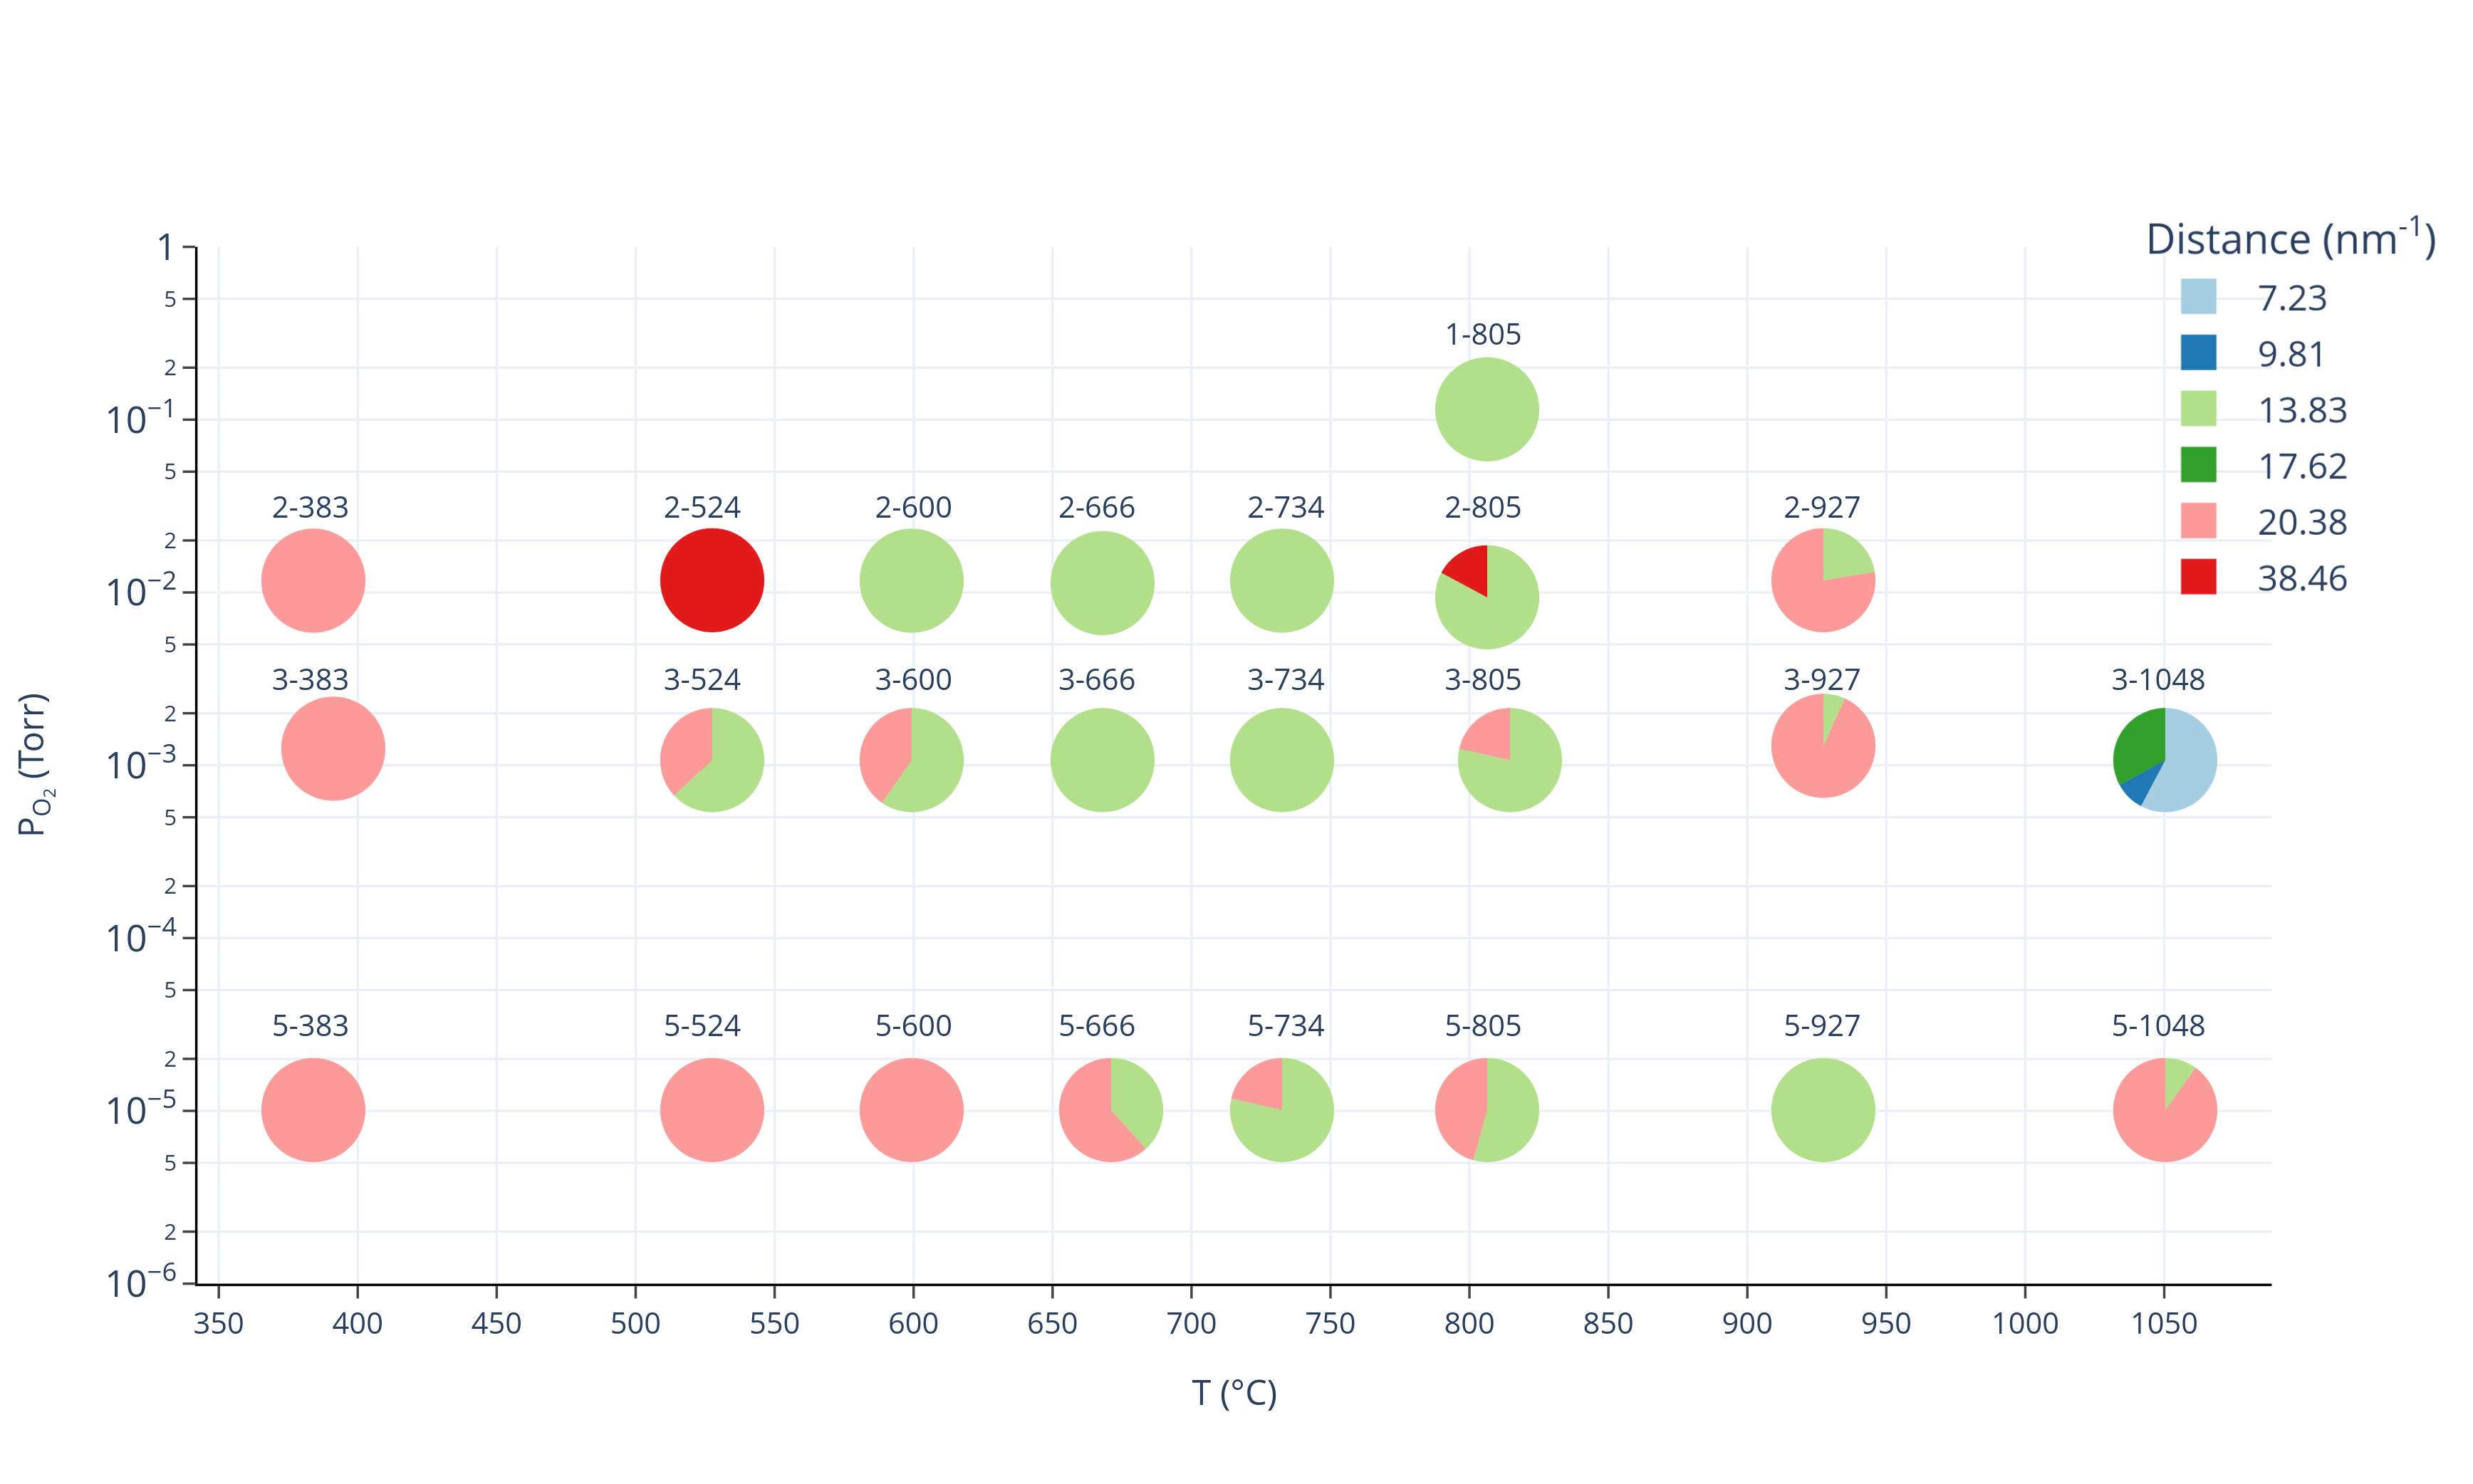

In [104]:
Image("publication/rheed_phase_map.png")

In [133]:
dgs = np.array([13.83, 20.38]) # we only looks at the two main distance

In [16]:
from rhana.io.kashiwa import *

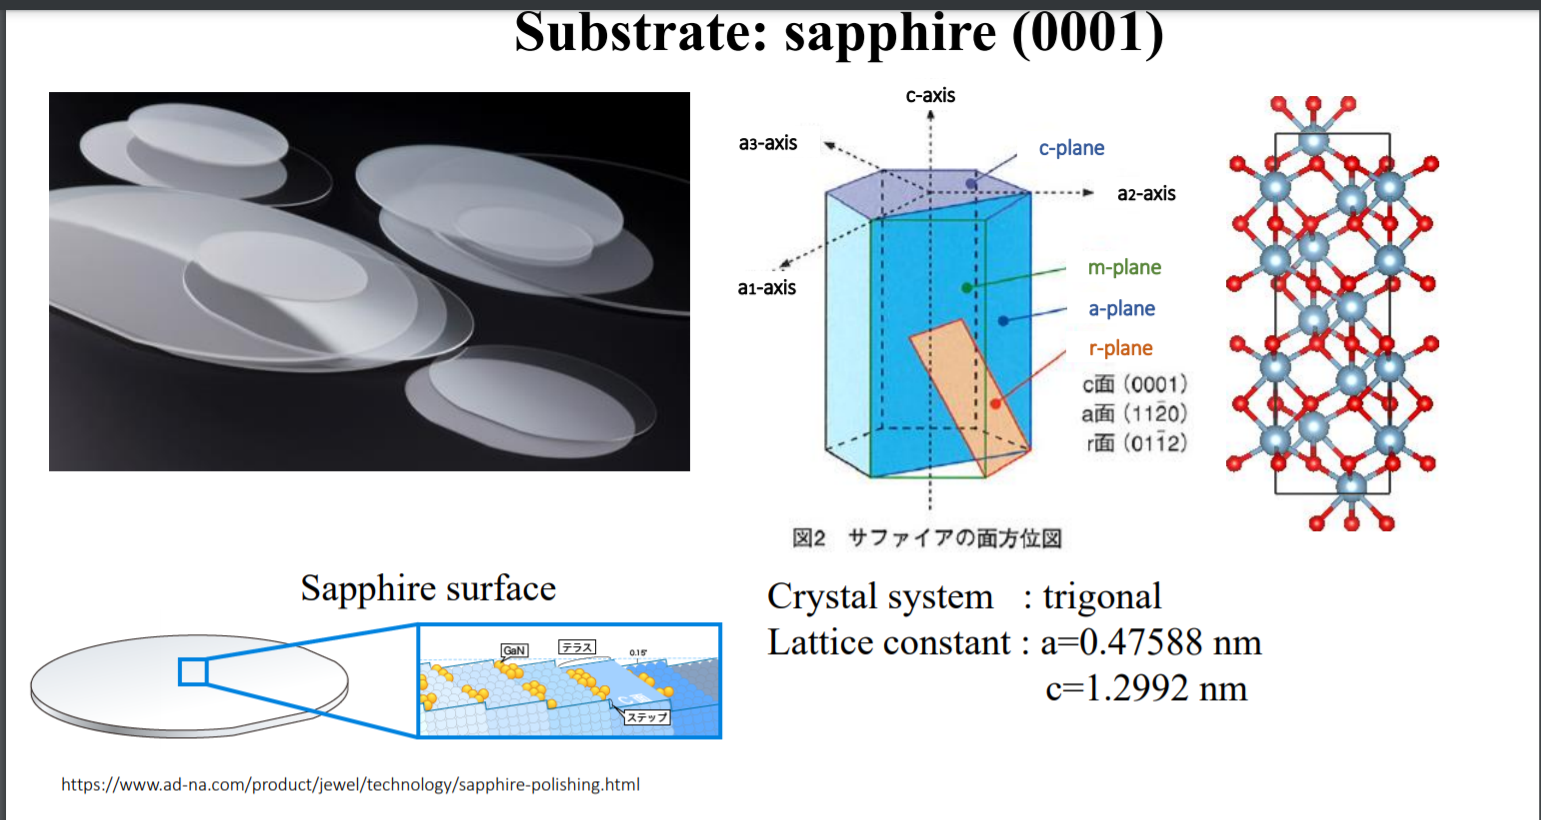

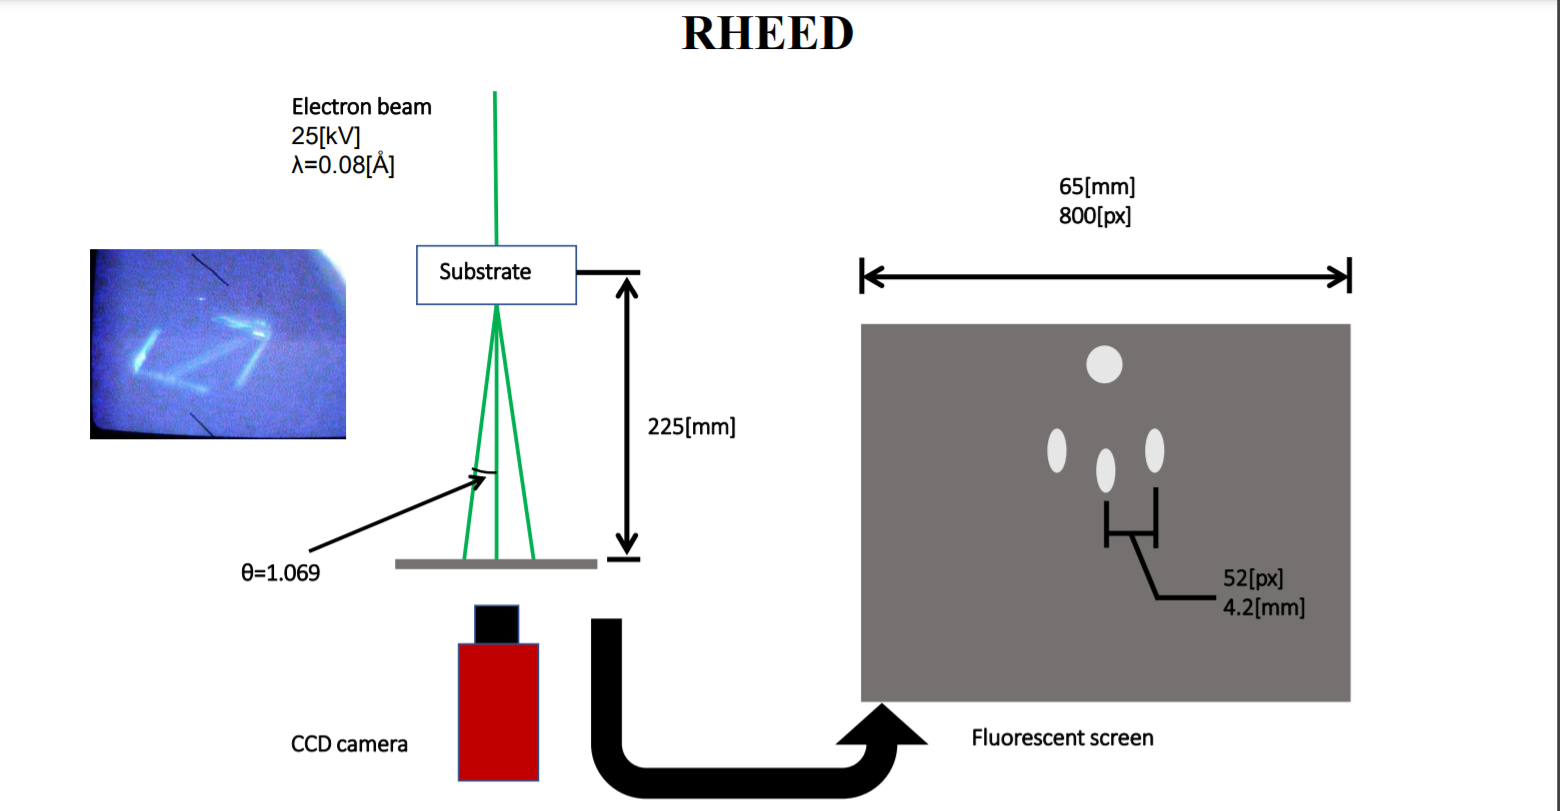

In [122]:
Fe2O3_indices, Fe2O3_dGs = generate_dGs(Fe2O3.lattice, n=4)
Fe3O4_indices, Fe3O4_dGs = generate_dGs(Fe3O4.lattice, n=4)

In [84]:
Fe2O3.lattice.matrix 

array([[ 4.98650000e+00,  0.00000000e+00,  3.05335063e-16],
       [-2.49325000e+00,  4.31843568e+00,  3.05335063e-16],
       [ 0.00000000e+00,  0.00000000e+00,  1.35016000e+01]])

In [85]:
direction = np.array([1, 2, 0])[None, :] @ Fe2O3.lattice.matrix 

In [86]:
Fe2O3.lattice.reciprocal_lattice.matrix

array([[ 1.26003917e+00,  7.27483952e-01,  0.00000000e+00],
       [ 0.00000000e+00,  1.45496790e+00,  0.00000000e+00],
       [-2.84954479e-17, -4.93555635e-17,  4.65365979e-01]])

In [87]:
def compute_G(hkl, lattice):
    plane = np.array(hkl)[None, :] @ lattice.reciprocal_lattice.matrix
    return plane

def compute_direction(ijk, lattice):
    direction = np.array(ijk)[None, :] @ lattice.matrix
    return direction

def is_ortho(direction, plane):
    cos_sim = ( (direction @ plane.T)[0][0] / np.linalg.norm(direction) / np.linalg.norm(plane) )
    
    return  abs(cos_sim) < 1e-5

In [88]:
plane = np.array([-2, 1, 0])[None, :] @ Fe2O3.lattice.reciprocal_lattice.matrix

In [89]:
direction

array([[2.66453526e-15, 8.63687135e+00, 9.16005190e-16]])

In [90]:
plane

array([[-2.52007833e+00,  8.88178420e-16,  0.00000000e+00]])

In [91]:
direction @ plane.T

array([[9.56245171e-16]])

In [92]:
is_ortho(direction, plane)

True

In [93]:
is_ortho(direction, direction)

False

In [94]:
Fe2O3_dGs[:5]

array([55.66431421, 54.28554163, 58.38447667, 55.66431421, 38.77510377])

In [95]:
print("Index", "G", sep="\t")
print("Miller", "nm-1", sep="\t")

idx = np.argsort(Fe2O3_dGs)
for i in range(len(Fe2O3_dGs)):
    print( " ".join(map(str, Fe2O3_indices[idx[i]])), round(Fe2O3_dGs[idx[i]]*10,2), sep="\t" )
    if i>10 : break

Index	G
Miller	nm-1
0 0 0	0.0
0 0 1	46.54
0 0 -1	46.54
0 0 2	93.07
0 0 -2	93.07
0 0 3	139.61
0 0 -3	139.61
0 1 0	145.5
0 -1 0	145.5
1 0 0	145.5
-1 0 0	145.5
-1 1 0	145.5


## Matching Phases

In [134]:
def match_phases(dGs, lattice_dGs, lattice_indices, thres=0.07):
    x = dGs
    y = lattice_dGs
    exp_cif_simi = pairwise_distances( x[:,None], y[:,None] )
    idx= np.where( exp_cif_simi < (dGs * thres)[:, None] )
    
    return idx

In [135]:
def plot_match(dGs, lattice_dGs, lattice_indices, idx, conditions=None):
    print("dG", "Index", "dG", sep="\t")
    print("nm-1", "Miller", "nm-1", sep="\t")

    for i, j in zip(*idx):
        if conditions is not None:
            flag = True
            for condition in conditions:
                flag = flag and condition(lattice_indices[j])
            if not flag:
                continue
        print(round(dGs[i],2), " ".join(map(str,lattice_indices[j])), round(lattice_dGs[j],2), sep="\t" )

### Match Fe2O3

In [136]:
idx = match_phases(dgs, Fe2O3_dGs, Fe2O3_indices, 0.3)

In [137]:
Fe2O3_direction = compute_direction((1, 1, 0), Fe2O3.lattice)

In [138]:
Fe2O3_direction

array([[2.49325000e+00, 4.31843568e+00, 6.10670126e-16]])

In [139]:
conditions = [
    lambda x: x[2]==0,
    lambda x: is_ortho(Fe2O3_direction, compute_G(x, Fe2O3.lattice) )
]

In [140]:
plot_match(dgs, Fe2O3_dGs, Fe2O3_indices, idx,  conditions)

dG	Index	dG
nm-1	Miller	nm-1
13.83	1 -1 0	14.55
13.83	-1 1 0	14.55
20.38	1 -1 0	14.55
20.38	-1 1 0	14.55


In [141]:
Fe2O3_direction @ compute_G((-1, 1, 0), Fe2O3.lattice).T

array([[4.4408921e-16]])

In [142]:
is_ortho(Fe2O3_direction, compute_G((-1, 1, 0), Fe2O3.lattice))

True

### Match Fe3O4

In [143]:
idx = match_phases(dgs, Fe3O4_dGs, Fe3O4_indices, 0.05)

In [144]:
plot_match(dgs, Fe3O4_dGs, Fe3O4_indices, idx,  None)

dG	Index	dG
nm-1	Miller	nm-1
20.38	2 0 -2	21.16
20.38	2 0 2	21.16
20.38	0 -2 -2	21.16
20.38	2 2 0	21.16
20.38	-2 -2 0	21.16
20.38	0 -2 2	21.16
20.38	0 2 -2	21.16
20.38	-2 0 -2	21.16
20.38	-2 0 2	21.16
20.38	2 -2 0	21.16
20.38	-2 2 0	21.16
20.38	0 2 2	21.16
